<a href="https://colab.research.google.com/github/AMindCoder/AMindCoder.github.io/blob/main/Semantic_Search_Course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This notebook provides a comprehensive guide to semantic search.
# It covers the fundamental concepts, key techniques, and practical applications of this powerful search paradigm.
# We will explore how to leverage natural language processing (NLP) and machine learning to understand the meaning behind user queries and retrieve relevant information.
# Throughout the notebook, we will delve into various aspects of semantic search, including:
#   - Understanding the limitations of traditional keyword-based search
#   - Exploring different embedding models (e.g., Word2Vec, GloVe, BERT)
#   - Implementing semantic search with Python libraries (e.g., Gensim, Transformers)
#   - Building a semantic search engine for specific domains
#   - Evaluating the performance of semantic search systems
# This notebook is designed for learners with a basic understanding of Python and NLP.
# By the end of this course, you will gain a solid foundation in semantic search and be able to apply these techniques to real-world problems.


# Building a Q/A App for Searching Countries data

We will be using dataset from this location : https://www.kaggle.com/datasets/fernandol/countries-of-the-world?resource=download


## What are Embeddings?
Embeddings are dense vector representations of data in a continuous vector space. They capture semantic meaning and relationships between different pieces of information in a way that machines can understand and process efficiently.

Lets generate an embedding with simple maths

In [2]:
# Sample data for a country
country_data = {
    "name": "France",
    "population": 60876136,
    "area": 547030,
    "gdp_per_capita": 27600,
    "literacy_rate": 99.0,
    "birthrate": 11.99,
    "deathrate": 9.14
}

# Simple function to create a vector (this is a basic example, not how we'll actually do it)
def create_country_vector(data):
    return [
        data["population"] / 1e8,  # Normalize population
        data["area"] / 1e6,        # Normalize area
        data["gdp_per_capita"] / 1e4,
        data["literacy_rate"] / 100,
        data["birthrate"] / 50,
        data["deathrate"] / 50
    ]

# Create the vector
france_vector = create_country_vector(country_data)
print(f"Vector representation of France: {france_vector}")

Vector representation of France: [0.60876136, 0.54703, 2.76, 0.99, 0.2398, 0.18280000000000002]


## Mathematical Foundations of Embeddings

Embeddings exist in a vector space, which is a mathematical structure where we can perform various operations. Understanding these operations is crucial for working with embeddings.
Key concepts:

- Vectors: An n-dimensional vector is an ordered list of n numbers. For our country embeddings, each number represents a feature of the country.
- Vector addition: We can add vectors component-wise. This can be useful for combining different aspects of our data.
- Scalar multiplication: We can multiply a vector by a scalar (a single number) to scale it.
- Dot product: This operation gives us a measure of similarity between vectors.

### Distance Metric

In our Countries Q&A application, we'll often need to measure how similar two countries are based on their embeddings. There are several ways to do this:

- Cosine Similarity: Measures the cosine of the angle between two vectors. It's particularly useful because it's independent of vector magnitude.
- Euclidean Distance: Measures the straight-line distance between two points in the vector space.
- Manhattan Distance: Measures the sum of the absolute differences of the vector components.

In [4]:
import numpy as np

def dot_product(v1, v2):
    return np.dot(v1, v2)

def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def euclidean_distance(v1, v2):
    return np.linalg.norm(v1 - v2)

def manhattan_distance(v1, v2):
    return np.sum(np.abs(v1 - v2))

# Example usage
france = np.array([0.60876136, 0.54703, 2.76, 0.99, 0.2398, 0.1828])
germany = np.array([0.82422299, 0.357021, 2.76, 0.99, 0.165, 0.2124])

print(f"Dot Product: {dot_product(france, germany)}")
print(f"Cosine Similarity: {cosine_similarity(france, germany)}")
print(f"Euclidean Distance: {euclidean_distance(france, germany)}")
print(f"Manhattan Distance: {manhattan_distance(france, germany)}")

# Demonstrate the relationship between dot product and cosine similarity
france_magnitude = np.linalg.norm(france)
germany_magnitude = np.linalg.norm(germany)

print("\nRelationship between Dot Product and Cosine Similarity:")
print(f"Dot Product / (||france|| * ||germany||) = {dot_product(france, germany) / (france_magnitude * germany_magnitude)}")
# Cosine similarity normalizes the dot product by the magnitudes of the vectors, making it invariant to scaling.
print(f"This should equal the Cosine Similarity: {cosine_similarity(france, germany)}")

Dot Product: 9.373150025965664
Cosine Similarity: 0.9952945803865813
Euclidean Distance: 0.2983258857076551
Manhattan Distance: 0.50987063

Relationship between Dot Product and Cosine Similarity:
Dot Product / (||france|| * ||germany||) = 0.9952945803865813
This should equal the Cosine Similarity: 0.9952945803865813



Understanding these relationships is crucial when working with embeddings, as it helps in choosing the right similarity metric for different tasks in our Countries Q&A system. For instance, we might use cosine similarity when we want to compare countries regardless of their "scale" (e.g., population size), while Euclidean distance might be more appropriate when the absolute magnitudes of the features are important.

## Types of Embeddings

Embeddings are versatile and can be applied to various types of data. Let's explore the main types:

- Word Embeddings
- Sentence/Document Embeddings
- Graph Embeddings
- Image Embeddings
- Audio/Video Embeddings

For this course, we will restrict the content only for Word and Sentence Embeddings

### Word Embeddings

Word embeddings represent words as dense vectors in a continuous vector space. They capture semantic relationships between words, allowing similar words to have similar representations.

#### Key Concepts:

- Distributional Hypothesis: Words that occur in similar contexts tend to have similar meanings.

- Vector Representation: Each word is represented as a vector of real numbers.

- Dimensionality: Typically ranges from 50 to 300 dimensions.

- Semantic Relationships: Captured through vector arithmetic (e.g., king - man + woman ≈ queen).

#### Popular Techniques:

- Word2Vec (CBOW and Skip-gram models)
- GloVe (Global Vectors for Word Representation)
- FastText

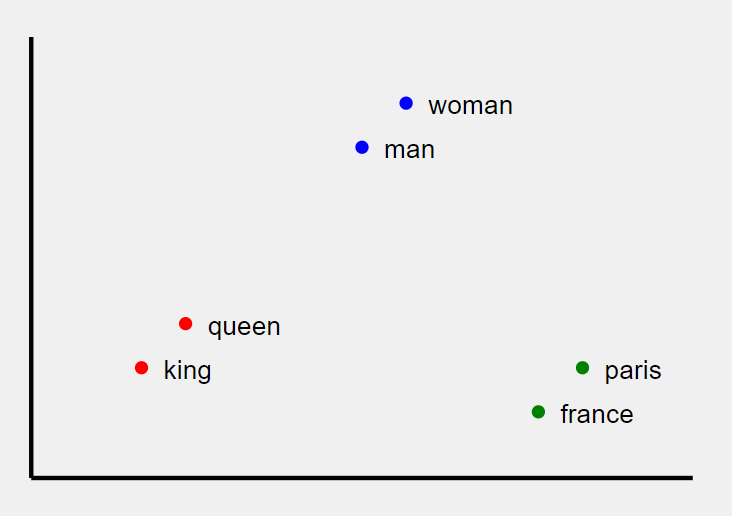

Now, let's implement word embeddings using our Countries dataset. We'll use the country names and some key words from their descriptions to create and visualize word embeddings.
First, we'll prepare our data and create word embeddings:

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re

# Load the dataset
df = pd.read_csv('data/countries_of_the_world.csv')

# Clean country names
df['Country'] = df['Country'].str.strip()

# Prepare the text data
def preprocess_text(text):
    return text.lower().replace(',', '').replace('&', 'and').replace(' ', '_')

# Combine country names with their regions
texts = [[preprocess_text(row['Country']), preprocess_text(row['Region'])] for _, row in df.iterrows()]

# Train Word2Vec model
model = Word2Vec(sentences=texts, vector_size=100, window=5, min_count=1, workers=4)

# Function to get word embedding
def get_word_embedding(word):
    return model.wv[word] if word in model.wv else None

# Get embeddings for all countries
country_embeddings = {}
for country in df['Country']:
    processed_name = preprocess_text(country)
    embedding = get_word_embedding(processed_name)
    if embedding is not None:
        country_embeddings[country] = embedding

print(f"Number of countries with embeddings: {len(country_embeddings)}")
print(f"Embedding dimension: {next(iter(country_embeddings.values())).shape[0]}")

# Example: Find similar countries
# Using cosine similarity
similar_countries = model.wv.most_similar(preprocess_text('United States'), topn=5)
print("\nCountries similar to United States:")
for country, similarity in similar_countries:
    print(f"{country}: {similarity:.2f}")

In [ ]:
# Visualization
countries = list(country_embeddings.keys())
embeddings = np.array(list(country_embeddings.values()))

# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Create the plot
plt.figure(figsize=(15, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6)

# Annotate some points
num_annotate = 20
np.random.seed(42)
indices = np.random.choice(len(countries), num_annotate, replace=False)
for idx in indices:
    plt.annotate(countries[idx], (embeddings_2d[idx, 0], embeddings_2d[idx, 1]))

plt.title('Word Embeddings of Countries')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.tight_layout()
plt.show()

In [ ]:
# Function to find nearest countries
def find_nearest_countries(country, n=5):
    country_emb = get_word_embedding(country.lower())
    if country_emb is None:
        return []

    distances = []
    for c, emb in country_embeddings.items():
        # doing Euclidean Distance
        distance = np.linalg.norm(country_emb - emb)
        distances.append((c, distance))

    return sorted(distances, key=lambda x: x[1])[:n]

# Example usage
print("\nNearest countries to France:")
for country, distance in find_nearest_countries('France'):
    print(f"{country}: {distance:.4f}")

# Example of Word Embeddings using Transformer Model


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

## GloVe Word Embeddings


In [2]:
import gensim.downloader as api
word_vectors = api.load('glove-wiki-gigaword-100')
#word_vectors = api.load('word2vec-google-news-300')

[==================================================] 100.0% 128.1/128.1MB downloaded


Lets access the vector data for a particular word

In [3]:
# Get vector for a specific word
vector = word_vectors['cat']
print("Vector for 'cat':", vector[:5])  # Print first 5 elements
print("Dimensions of the vector : ", word_vectors['cat'].shape[0])

Vector for 'cat': [ 0.23088  0.28283  0.6318  -0.59411 -0.58599]
Dimensions of the vector :  100


Now we will try to visualize the vector data

In [4]:
# Define the words for the analogy
king = word_vectors['king']
man = word_vectors['man']
woman = word_vectors['woman']

# Perform the vector arithmetic
result_vector = king - man + woman

# Find the word closest to the result vector
closest_words = word_vectors.most_similar([result_vector], topn=5)

print("king - man + woman:")
for word, score in closest_words:
    print(f"{word}: {score}")

# Check if 'queen' is in the vocabulary
if 'queen' in word_vectors:
    queen = word_vectors['queen']
    similarity = cosine_similarity([result_vector], [queen])[0][0]
    print(f"\nSimilarity between result and 'queen': {similarity}")
else:
    print("\n'queen' is not in the vocabulary.")

king - man + woman:
king: 0.8551837205886841
queen: 0.783441424369812
monarch: 0.6933802366256714
throne: 0.6833109855651855
daughter: 0.6809081435203552

Similarity between result and 'queen': 0.7834413647651672


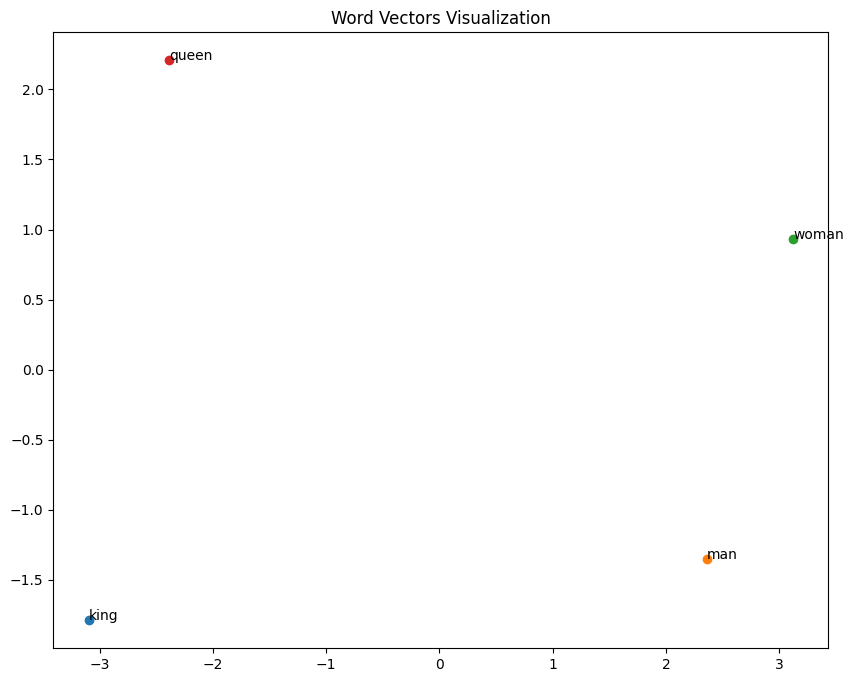

In [5]:
# Visualize the vectors in 2D
def plot_words(word_vectors, words):
    vectors = [word_vectors[word] for word in words if word in word_vectors]
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)

    plt.figure(figsize=(10, 8))
    for i, word in enumerate(words):
        if word in word_vectors:
            plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1])
            plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]))

    plt.title("Word Vectors Visualization")
    plt.show()

# Plot the words
plot_words(word_vectors, ['king', 'man', 'woman', 'queen'])

## Embeddings using BERT



In [7]:
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
model = BertModel.from_pretrained('google-bert/bert-base-uncased')

# Function to get BERT embeddings
def get_bert_embeddings(sentence, word):
    inputs = tokenizer(sentence, return_tensors='pt')
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    word_tokens = tokenizer.tokenize(sentence)
    word_index = word_tokens.index(word)
    word_embedding = last_hidden_states[0, word_index + 1, :]  # +1 to account for [CLS] token
    return word_embedding

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [8]:
sentence1 = "The bank of the river was covered in wildflowers."
sentence2 = "I need to go to the bank to deposit my paycheck."

word = "bank"

bert_embedding1 = get_bert_embeddings(sentence1, word).detach().numpy()
bert_embedding2 = get_bert_embeddings(sentence2, word).detach().numpy()
word_embedding = word_vectors[word]

In [9]:
print("BERT Embedding for 'bank' in sentence 1:", bert_embedding1[:5])
print("BERT Embedding for 'bank' in sentence 2:", bert_embedding2[:5])
print("GloVe Embedding for 'bank':", word_embedding[:5])

bert_similarity = cosine_similarity([bert_embedding1], [bert_embedding2])[0][0]
word_embedding_similarity = cosine_similarity([word_embedding], [word_embedding])[0][0]

print()
print(f"Cosine Similarity between BERT embeddings in different contexts: {bert_similarity}")
print(f"Cosine Similarity between GloVe embeddings: {word_embedding_similarity}")


BERT Embedding for 'bank' in sentence 1: [-0.5606096  -0.57269895 -0.26337966 -0.174796   -0.04644477]
BERT Embedding for 'bank' in sentence 2: [ 0.5647569  -0.2226696   0.150411   -0.22132452  1.3779224 ]
GloVe Embedding for 'bank': [ 0.41869  -0.92211   0.048684  0.11798   0.22062 ]

Cosine Similarity between BERT embeddings in different contexts: 0.45202651619911194
Cosine Similarity between GloVe embeddings: 1.0


## Sentence Embeddings



In [12]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

In [13]:
def get_sentence_embedding(sentence):
    encoded_input = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')
    attention_mask = encoded_input['attention_mask']   # to indicate which tokens are valid and which are padding

    # Get the model output (without the specific classification head)
    with torch.no_grad():
        output = model(**encoded_input)

    token_embeddings = output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

    # mean pooling operation, considering the BERT input_mask and padding
    sentence_embedding = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    return sentence_embedding.flatten().tolist()

In [14]:
def cosine_similarity_matrix(features):
    norms = np.linalg.norm(features, axis=1, keepdims=True)
    normalized_features = features / norms
    similarity_matrix = np.inner(normalized_features, normalized_features)
    rounded_similarity_matrix = np.round(similarity_matrix, 4)
    return rounded_similarity_matrix

In [15]:
# Helper function to plot similarity matrix
def plot_similarity(labels, features, rotation):
    sim = cosine_similarity_matrix(features)
    sns.set_theme(font_scale=1.2)
    g = sns.heatmap(sim, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")
    return g

In [11]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 5.5 MB/s eta 0:00:00


In [16]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<Axes: title={'center': 'Semantic Textual Similarity'}>

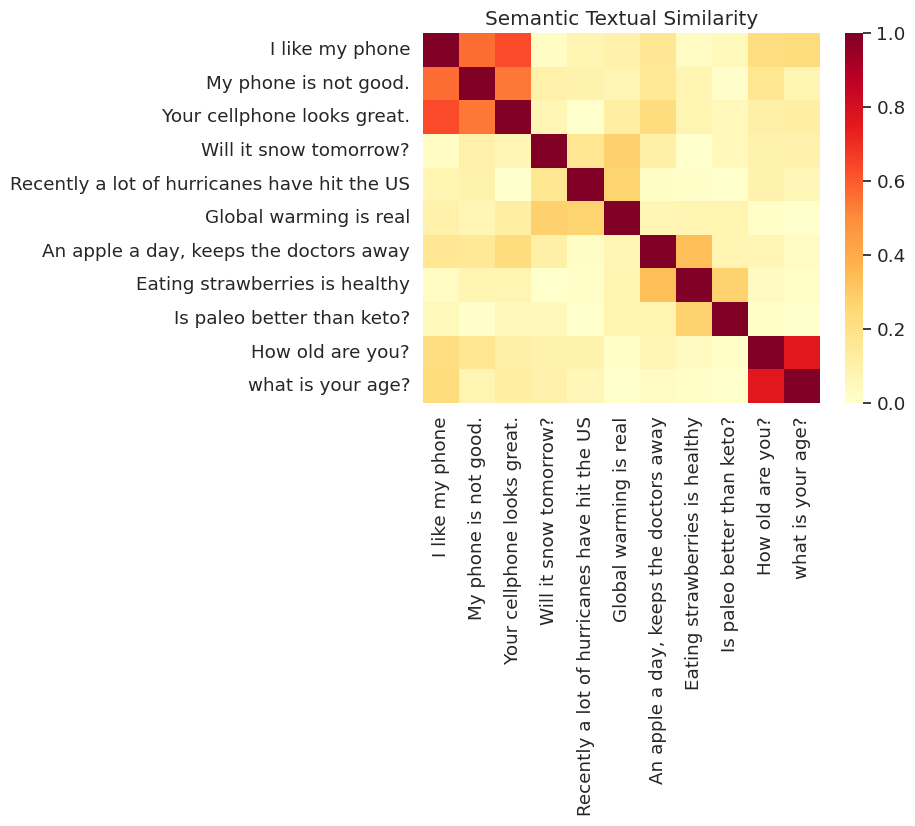

In [17]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embeddings = []
for t in messages:
    emb = list(model.encode(t))
    embeddings.append(emb)

plot_similarity(messages, embeddings, 90)